Import all necessary libraries

In [ ]:
pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, average_precision_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance


In [ ]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [ ]:
raw_df = pd.read_csv('/content/driver/My Drive/rawdataset.csv')
raw_df = raw_df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [ ]:
raw_df

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
raw_df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
raw_df.isnull().values.any()

False

In [ ]:
def missing_info(column, df):
    na = df[column].isna()
    count = na.sum()
    total_count = df.shape[0]
    miss_prcnt = np.round((count/total_count)*100,3)

    return (count, miss_prcnt)

In [ ]:
def missing_train_info(df):
  columns_missing_info = []

  for column in df:

      count, miss_prcnt = missing_info(column, df);

      if(count):
          columns_missing_info.append([column, count, miss_prcnt])
  column_names = ['Feature_Name', 'Missing_Count', 'Missing_Percentage']

  missing_info_df = pd.DataFrame(data = columns_missing_info, columns = column_names)

  return missing_info_df


In [ ]:
missing_train_df = missing_train_info(raw_df)
missing_train_df

,Feature_Name,Missing_Count,Missing_Percentage


# Data Analysis

In [ ]:
type_counts = raw_df['isFraud'].value_counts()

data = pd.DataFrame({
    'Labels': ['Not Fraud', 'Fraud'],
    'Counts': type_counts.values
})

fig = px.pie(data, values='Counts', names='Labels', title='Distribution of Transaction Types',
             labels={'Counts': 'Count'}, hole=0.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(width=600, height=500)
fig.show()


In [ ]:
type_counts = raw_df['type'].value_counts()
data = pd.DataFrame({
    'Labels': type_counts.index,
    'Counts': type_counts.values
})

fig = px.pie(data, values='Counts', names='Labels', title='Distribution of Transaction Types',
             labels={'Counts': 'Count'}, hole=0.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(width=600, height=500)
fig.show()

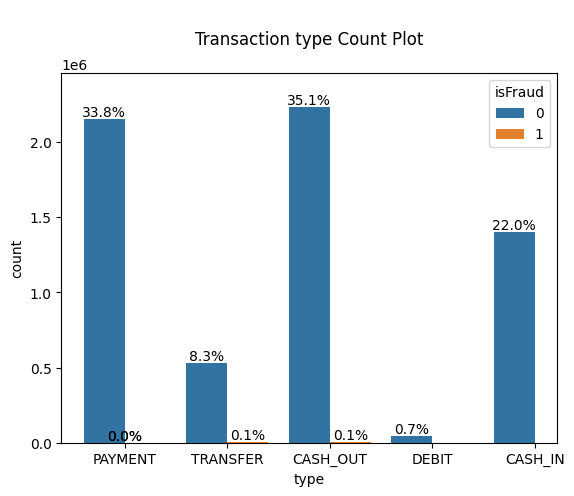

In [ ]:
ax = sns.countplot(x='type', hue='isFraud', data = raw_df)

plt.margins(0.05, 0.1)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{:.1f}%'.format(100.*y/len(raw_df)), (x.mean(), y),
          ha='center', va='bottom')

plt.title('\nTransaction type Count Plot\n')
plt.show()

In [ ]:
print('\n The types of fraudulent transactions are {}'.format(\
list(raw_df.loc[raw_df.isFraud == 1].type.drop_duplicates().values)))

FraudTransfer = raw_df.loc[(raw_df.isFraud == 1) & (raw_df.type == 'TRANSFER')]
FraudCashout = raw_df.loc[(raw_df.isFraud == 1) & (raw_df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(FraudTransfer)))

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(FraudCashout)))



 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [ ]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(raw_df.loc[raw_df.isFlaggedFraud == 1].type.drop_duplicates())))

dfTransfer = raw_df.loc[raw_df.type == 'TRANSFER']
dfFlagged = raw_df.loc[raw_df.isFlaggedFraud == 1]
dfNotFlagged = raw_df.loc[raw_df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min()))

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set =\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max()))


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set = 92445516.64


In [ ]:
df_timeofday = raw_df
df_timeofday['step'] = df_timeofday['step'] % 24
df_timeofday = df_timeofday[df_timeofday['isFraud'] == 1]

hourly_fraud = df_timeofday.groupby('step').size()

plotly_df = pd.DataFrame({'Hour': hourly_fraud.index, 'Fraudulent Transactions': hourly_fraud.values})

# Create an interactive bar chart using Plotly
fig = px.bar(plotly_df, x='Hour', y='Fraudulent Transactions',
             labels={'Hour': 'Hour of Day', 'Fraudulent Transactions': 'Number of Fraudulent Transactions'},
             title='Number of Fraudulent Transactions By Hour of Day')

fig.update_layout(xaxis={'title': 'Hour of Day', 'tickvals': list(range(0, 24))})  # Setting x-axis ticks
fig.update_layout(width=900, height=500)

fig.show()

In [ ]:
def results(y_actual, y_pred):
  cm = confusion_matrix(y_actual, y_pred)
  results_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})

  TP = cm[1, 1]
  FP = cm[0, 1]
  TN = cm[0, 0]
  FN = cm[1, 0]

  precision_transactions = TP / (TP + FP) if (TP + FP) else 0
  recall_transactions = TP / (TP + FN) if (TP + FN) else 0
  f1_score_transactions = 2 * precision_transactions * recall_transactions / (precision_transactions + recall_transactions) if (precision_transactions + recall_transactions) else 0


  TPR = TP / (TP + FN)
  FPR = FP / (FP + TN)
  TNR = TN / (TN + FP)
  FNR = FN / (TP + FN)

  accuracy_transactions = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) else 0

  print(f"True Positive Rate: {TPR}")
  print(f"False Positive Rate: {FPR}")
  print(f"True Negative Rate: {TNR}")
  print(f"False Negative Rate: {FNR}")

  print(f"Accuracy : {accuracy_transactions}")

  print(f"F1 Score : {f1_score_transactions}")



#Feature Engineering

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import plotly.figure_factory as ff

encoder = OneHotEncoder(sparse_output=False)
type_reshaped = raw_df['type'].values.reshape(-1, 1)
type_encoded = encoder.fit_transform(type_reshaped)
type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))
df_encoded = pd.concat([raw_df, type_encoded_df], axis=1)
df_encoded.drop('type', axis=1, inplace=True)

df_encoded['destBalanceDiff'] = df_encoded['newBalanceDest'] - df_encoded['oldBalanceDest']
df_encoded['orgBalanceDiff'] = df_encoded['newBalanceOrig'] - df_encoded['oldBalanceOrig']

df_encoded.drop(['step', 'nameOrig', 'nameDest', 'newBalanceOrig', 'oldBalanceOrig', 'newBalanceDest', 'oldBalanceDest'], axis=1, inplace=True)

heatmap_matrix = df_encoded[['amount', 'isFraud', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'destBalanceDiff', 'orgBalanceDiff']]
columns = ['amount', 'isFraud', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'destBalanceDiff', 'orgBalanceDiff']

corr_matrix = heatmap_matrix.corr()

column_names = heatmap_matrix.columns.tolist()

fig = ff.create_annotated_heatmap(z=corr_matrix.values, x=column_names, y=column_names,
                                  annotation_text=corr_matrix.round(2).values,
                                  colorscale='RdBu', showscale=True)

fig.update_layout(title='Correlation Heatmap for Various Numeric Features',
                  xaxis_title='Features', yaxis_title='Features')
fig.update_layout(width=900, height=1000)
fig.update_xaxes(side="bottom")
fig.show()

In [ ]:
df_encoded

,amount,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,destBalanceDiff,orgBalanceDiff
0,9839.64,0,0,0.0,0.0,0.0,1.0,0.0,0.00,-9839.64
1,1864.28,0,0,0.0,0.0,0.0,1.0,0.0,0.00,-1864.28
2,181.00,1,0,0.0,0.0,0.0,0.0,1.0,0.00,-181.00
3,181.00,1,0,0.0,1.0,0.0,0.0,0.0,-21182.00,-181.00
4,11668.14,0,0,0.0,0.0,0.0,1.0,0.0,0.00,-11668.14
...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,1,0,0.0,1.0,0.0,0.0,0.0,339682.13,-339682.13
6362616,6311409.28,1,0,0.0,0.0,0.0,0.0,1.0,0.00,-6311409.28
6362617,6311409.28,1,0,0.0,1.0,0.0,0.0,0.0,6311409.27,-6311409.28
6362618,850002.52,1,0,0.0,0.0,0.0,0.0,1.0,0.00,-850002.52


#Baseline Performance

Logistic Regression for baseline

In [ ]:
from sklearn.linear_model import LogisticRegression

features = df_encoded.drop(columns = ['isFraud', 'isFlaggedFraud'])
labels = df_encoded['isFraud']
amount = df_encoded['amount']

In [ ]:
seed = 42
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, random_state=seed
)

In [ ]:
LRclf = LogisticRegression(penalty = None, multi_class='multinomial').fit(X_train, y_train)
y_train_pred = LRclf.predict(X_train)
y_pred = LRclf.predict(X_val)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
log_acc = LRclf.score(X_val, y_val)
log_acc #this is obviously high due to the fact that there is so much less fraudulent data than non fraudulent

0.9980126111570391

In [ ]:
print("Train Results: ", accuracy_score(y_train, y_train_pred))
results(y_val, y_pred)

Train Results:  0.9979959120613835
True Positive Rate: 0.0006172839506172839
False Positive Rate: 0.0007160257580430937
True Negative Rate: 0.9992839742419569
False Negative Rate: 0.9993827160493827
Accuracy : 0.9980126111570391
F1 Score : 0.0007902015013828526


#Handling imbalanced data

In [ ]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.15, random_state=seed
)

In [ ]:
# features
X = X_train
# labels
y = y_train

# Oversample
ros = RandomOverSampler(sampling_strategy=0.5, random_state=1)
X_oversample, y_oversample = ros.fit_resample(X, y)

# Undersample
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=1)
X_balanced, y_balanced = rus.fit_resample(X_oversample, y_oversample)

#Principle Components Analysis

In [ ]:
target_balanced = y_balanced

scaler = StandardScaler()
X_balanced_scaled = scaler.fit_transform(X_balanced)
X_test_scaled= scaler.transform(X_test)

pca = PCA()
pca.fit(X_balanced_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)



In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Add trace for cumulative variance
fig.add_trace(go.Scatter(x=np.arange(1, len(cumulative_variance) + 1), y=cumulative_variance,
                         mode='lines+markers', marker=dict(color='blue'), line=dict(shape='linear')))

# Update layout and axis labels
fig.update_layout(title='Explained Variance vs. Number of Components',
                  xaxis_title='Number of Components', yaxis_title='Cumulative Explained Variance')
fig.update_layout(width=900, height=500)

fig.show()

In [ ]:
threshold = 0.95
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f'Number of components that need to be retained to reach {threshold * 100}% variance: {num_components}')

Number of components that need to be retained to reach 95.0% variance: 5


In [ ]:
pca = PCA(n_components=5)
features_balanced_pca = pca.fit_transform(X_balanced_scaled)
test_features_pca = pca.transform(X_test_scaled)

#Machine Learning models

Logistic Regression + Hyperparameters Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
lg_balanced = LogisticRegression(multi_class = 'multinomial',solver = 'saga')

param_grid = {
  'penalty': ['l1', 'l2', 'none'],  # Regularization types
}

grid_search = GridSearchCV(estimator=lg_balanced, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(features_balanced_pca, y_balanced)

print("Best parameters found: ", grid_search.best_params_)

best_lg_balanced = grid_search.best_estimator_

y_train_pred = best_lg_balanced.predict(features_balanced_pca)
y_pred_balanced = best_lg_balanced.predict(test_features_pca)

# Evaluate the model
log_acc_balanced = best_lg_balanced.score(test_features_pca, y_test)
print("Logistic Regression Accuracy (Balanced):", log_acc_balanced)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Best parameters found:  {'penalty': 'none'}
Logistic Regression Accuracy (Balanced): 0.9351200186925093


In [ ]:
results(y_test, y_pred_balanced)

True Positive Rate: 0.8984179850124896
False Positive Rate: 0.06483373758906914
True Negative Rate: 0.9351662624109308
False Negative Rate: 0.1015820149875104
Accuracy : 0.9351200186925093
F1 Score : 0.03367717973126922


Random Forest + Hyperparameters Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define your RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters to tune
# Here you can add more parameters and values according to your requirements
param_grid = {
    'n_estimators': [10, 20, 30],  # Number of trees in the forest
    'max_depth': [None, 5, 10],    # Maximum depth of the tree
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(features_balanced_pca, y_balanced)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_train_pred = best_rf.predict(features_balanced_pca)
y_pred_rf = best_rf.predict(test_features_pca)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'max_depth': None, 'n_estimators': 30}


In [ ]:
print("Train accuracy: ", accuracy_score(y_balanced, y_train_pred))
results(y_test, y_pred_rf)

Train accuracy:  0.9999435312135383
True Positive Rate: 0.7327227310574521
False Positive Rate: 0.000748012992135897
True Negative Rate: 0.9992519870078641
False Negative Rate: 0.2672772689425479
Accuracy : 0.9989165888685269
F1 Score : 0.6299212598425196


XGBoost + Hyperparameters Tuning

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(features_balanced_pca, label=y_balanced)
dtest = xgb.DMatrix(test_features_pca, y_test)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_jobs=4, eval_metric='auc')

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 70],
}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=2, scoring='f1', verbose=2)

grid_search.fit(features_balanced_pca, y_balanced)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=  13.2s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=  13.7s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=70; total time=  15.8s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=70; total time=  15.7s
[CV] END ...learning_rate=0.05, max_depth=5, n_estimators=50; total time=  14.6s
[CV] END ...learning_rate=0.05, max_depth=5, n_estimators=50; total time=  14.6s
[CV] END ...learning_rate=0.05, max_depth=5, n_estimators=70; total time=  18.1s
[CV] END ...learning_rate=0.05, max_depth=5, n_estimators=70; total time=  19.8s
[CV] END ...learning_rate=0.05, max_depth=7, n_estimators=50; total time=  17.1s
[CV] END ...learning_rate=0.05, max_depth=7, n_estimators=50; total time=  16.7s
[CV] END ...learning_rate=0.05, max_depth=7, n_estimators=70; total time=  21.5s
[CV] END ...learning_rate=0.05, max_depth=7, n_e

In [ ]:
optimized_xgb = xgb.XGBClassifier(
    learning_rate= 0.3,
    max_depth=7,
    n_estimators=70,
    objective='binary:logistic',
    n_jobs=4,
    eval_metric='auc'
)

optimized_xgb.fit(features_balanced_pca, y_balanced)
y_pred_test = optimized_xgb.predict(test_features_pca)


In [ ]:
print("Train accuracy: ", accuracy_score(y_balanced, y_train_pred))
results(y_test, y_pred_test)

Train accuracy:  0.9999435312135383
True Positive Rate: 0.9833472106577852
False Positive Rate: 0.03915580491653308
True Negative Rate: 0.960844195083467
False Negative Rate: 0.01665278934221482
Accuracy : 0.9608725126860738
F1 Score : 0.059488729379171386


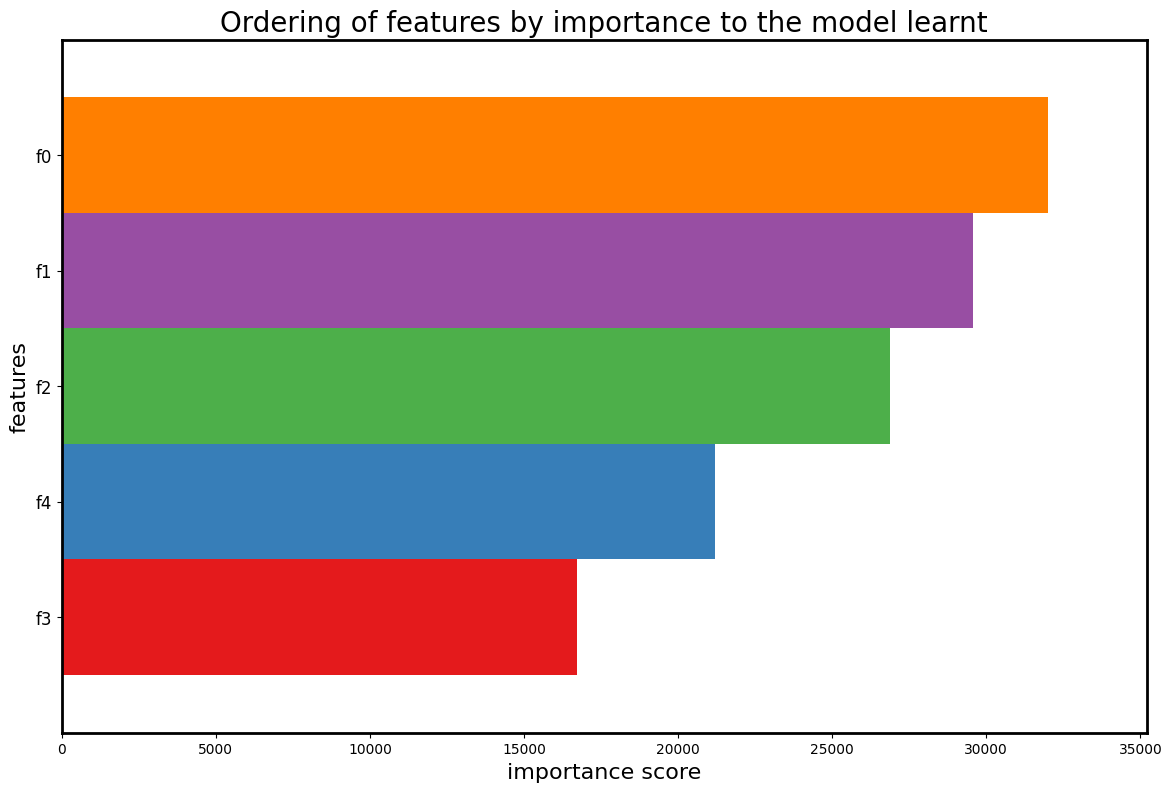

In [ ]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(optimized_xgb, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

#Bagging models